In [2]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 12.8/12.8 MB 4.5 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt 
import seaborn as sns 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import plotly.express as px
from plotly.offline import init_notebook_mode
import re
import nltk
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer
import spacy

tqdm.pandas()
spacy_eng = spacy.load("en_core_web_sm")
nltk.download('stopwords')
lemm = WordNetLemmatizer()
init_notebook_mode(connected=True)
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 18

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Text Classification: Using Transformers Encoder Block
- A transformer is a deep learning model that adopts the mechanism of self-attention, differentially weighting the significance of each part of the input data
- They hold the potential to understand the relationshipbetween sequential elements that are far from each other
- They are way more accurate 
- They pay equal attention to all the elements in the sequence

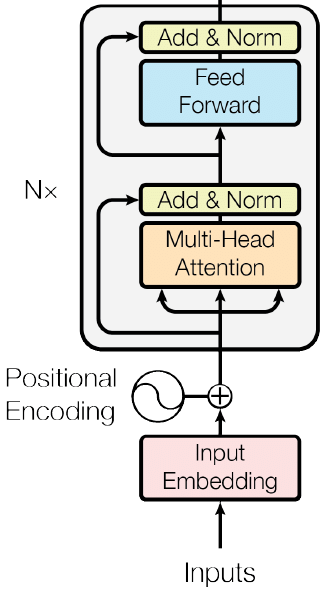

In [4]:
data1 = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
data2 = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)

In [5]:
data1 = data1[['headline','is_sarcastic']]
data2 = data2[['headline','is_sarcastic']]

data = pd.concat([data1,data2])
data.reset_index(drop=True, inplace=True)

In [6]:
data

,headline,is_sarcastic
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep. totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1
...,...,...
55323,american politics in moral free-fall,0
55324,america's best 20 hikes,0
55325,reparations and obama,0
55326,israeli ban targeting boycott supporters raise...,0


# EDA and Text Preprocessing

## Checking for Missing Values

In [7]:
data.isnull().sum()

headline        0
is_sarcastic    0
dtype: int64

## Finding the Classes Balance/Imbalance

In [8]:
px.bar(data.groupby('is_sarcastic').count().reset_index(), x='headline',title='Count of Sarcastic and Genuine Headlines')

## Special Characters Removal
- We will not remove numbers from the text data right away, lets further analyse if they contain any relevant information
- We can find the entity type of the tokens in the sentences using Named Entity Recognition (NER), this will help us identify the type and relevance of numbers in our text data

In [9]:
stop_words = stopwords.words('english')
stop_words.remove('not')

def text_cleaning(x):
    
    headline = re.sub('\s+\n+', ' ', x)
    headline = re.sub('[^a-zA-Z0-9]', ' ', x)
    headline = headline.lower()
    headline = headline.split()
    
    headline = [lemm.lemmatize(word, "v") for word in headline if not word in stop_words]
    headline = ' '.join(headline)
    
    return headline

In [10]:
def get_entities(x):
    entity = []
    text = spacy_eng(x)
    for word in text.ents:
        entity.append(word.label_)
    return ",".join(entity)

data['entity'] = data['headline'].progress_apply(get_entities)

100%|███████████████████████████████████████████████████████████████████████████| 55328/55328 [05:17<00:00, 174.03it/s]


In [11]:
data['clean_headline'] = data['headline'].apply(text_cleaning)

In [12]:
data['sentence_length'] = data['clean_headline'].apply(lambda x: len(x.split()))
data

,headline,is_sarcastic,entity,clean_headline,sentence_length
0,thirtysomething scientists unveil doomsday clo...,1,DATE,thirtysomething scientists unveil doomsday clo...,7
1,dem rep. totally nails why congress is falling...,0,"ORG,ORG",dem rep totally nail congress fall short gende...,10
2,eat your veggies: 9 deliciously different recipes,0,CARDINAL,eat veggies 9 deliciously different recipes,6
3,inclement weather prevents liar from getting t...,1,,inclement weather prevent liar get work,6
4,mother comes pretty close to using word 'strea...,1,,mother come pretty close use word stream corre...,8
...,...,...,...,...,...
55323,american politics in moral free-fall,0,NORP,american politics moral free fall,5
55324,america's best 20 hikes,0,"GPE,CARDINAL",america best 20 hike,4
55325,reparations and obama,0,,reparations obama,2
55326,israeli ban targeting boycott supporters raise...,0,NORP,israeli ban target boycott supporters raise al...,8


## Headlines Length Distribution
- Look for outlier length of headline sentences
- Usually the headlines shouldn't be more than 20-30 words

In [13]:
px.histogram(data, x="sentence_length",height=700, color='is_sarcastic', title="Headlines Length Distribution", marginal="box")

In [14]:
data[data['sentence_length']==107]['headline']

7302    hot wheels ranked number one toy for rolling d...
Name: headline, dtype: object

In [15]:
data.drop(data[data['sentence_length'] == 107].index, inplace = True)
data.reset_index(inplace=True, drop=True)

## Headlines Length Distribution: Outliers Removed
- The headlines after the removal of outliers do not exceed the limit of 20-30 words
- They are mostly centered in the range of 5-10 words

In [16]:
px.histogram(data, x="sentence_length",height=700, color='is_sarcastic', title="Headlines Length Distribution", marginal="box")

## Filtering: Find Sentences that Contain Numbers

In [17]:
data['contains_number'] = data['clean_headline'].apply(lambda x: bool(re.search(r'\d+', x)))
data

,headline,is_sarcastic,entity,clean_headline,sentence_length,contains_number
0,thirtysomething scientists unveil doomsday clo...,1,DATE,thirtysomething scientists unveil doomsday clo...,7,False
1,dem rep. totally nails why congress is falling...,0,"ORG,ORG",dem rep totally nail congress fall short gende...,10,False
2,eat your veggies: 9 deliciously different recipes,0,CARDINAL,eat veggies 9 deliciously different recipes,6,True
3,inclement weather prevents liar from getting t...,1,,inclement weather prevent liar get work,6,False
4,mother comes pretty close to using word 'strea...,1,,mother come pretty close use word stream corre...,8,False
...,...,...,...,...,...,...
55322,american politics in moral free-fall,0,NORP,american politics moral free fall,5,False
55323,america's best 20 hikes,0,"GPE,CARDINAL",america best 20 hike,4,True
55324,reparations and obama,0,,reparations obama,2,False
55325,israeli ban targeting boycott supporters raise...,0,NORP,israeli ban target boycott supporters raise al...,8,False


### Analysis of Samples Containing numbers of Time, Date or Cardinal Entity type
- The numbers in a text data can have different implications
- While the naive text preprocessing methods suggest that the numbers should be removed along with the special characters
- The entity type of these numbers should be identified to get their exact implications

### 10 Random Samples: Date Entity 

In [18]:
data[(data['contains_number']) & (data['sentence_length']<=5) & (data['entity']=='DATE')].sample(10)

,headline,is_sarcastic,entity,clean_headline,sentence_length,contains_number
26656,"news roundup for august 17, 2017",0,DATE,news roundup august 17 2017,5,True
47546,listen up! my favorite americana discoveries o...,0,DATE,listen favorite americana discoveries 2014,5,True
1983,6 summer salads you'll actually crave,0,DATE,6 summer salads actually crave,5,True
1939,here's what is coming to amazon in april 2018,0,DATE,come amazon april 2018,4,True
28899,6 summer salads you'll actually crave,0,DATE,6 summer salads actually crave,5,True
50304,mindfulness in your 20s: lessons i learned fro...,0,DATE,mindfulness 20s lessons learn hitchhiker,5,True
51330,mysteryland 2014 set times announced,0,DATE,mysteryland 2014 set time announce,5,True
2630,"news roundup for august 29, 2017",0,DATE,news roundup august 29 2017,5,True
7508,elevate your leadership in 2016,0,DATE,elevate leadership 2016,3,True
55050,watch maroon 5's 'snl' performance,0,DATE,watch maroon 5 snl performance,5,True


### 10 Random Samples: Time Entity

In [19]:
data[(data['contains_number']) & (data['sentence_length']<=5) & (data['entity']=='TIME')].sample(10)

,headline,is_sarcastic,entity,clean_headline,sentence_length,contains_number
54313,oven preheated for 16 seconds,1,TIME,oven preheat 16 second,4,True
39547,man turns vegetarian for 36 hours,1,TIME,man turn vegetarian 36 hours,5,True
25836,23-hour suicide watch a failure,1,TIME,23 hour suicide watch failure,5,True
31624,"how to be nicer, healthier and more focused in...",0,TIME,nicer healthier focus 15 minutes,5,True
23122,'vacation is when i have a 40-hour week',0,TIME,vacation 40 hour week,4,True
18283,5-minute hairstyles -- for real!,0,TIME,5 minute hairstyles real,4,True
47428,5-minute hairstyles -- for real!,0,TIME,5 minute hairstyles real,4,True
29312,day chalked up as loss by 10:15 a.m.,1,TIME,day chalk loss 10 15,5,True
21538,jcpenney abandons 45-second sale,1,TIME,jcpenney abandon 45 second sale,5,True
35268,23-hour suicide watch a failure,1,TIME,23 hour suicide watch failure,5,True


### 10 Random Samples: Cardinal Entity

In [20]:
data[(data['contains_number']) & (data['sentence_length']<=5) & (data['entity']=='CARDINAL')].sample(10)

,headline,is_sarcastic,entity,clean_headline,sentence_length,contains_number
31293,top 10 college basketball seniors,0,CARDINAL,top 10 college basketball seniors,5,True
36117,preview expiration test 2,0,CARDINAL,preview expiration test 2,4,True
23304,16 fashionable sneakers you can wear to work,0,CARDINAL,16 fashionable sneakers wear work,5,True
47186,22 animals wearing pajamas just because,0,CARDINAL,22 animals wear pajamas,4,True
14365,19 times shorter was way better,0,CARDINAL,19 time shorter way better,5,True
20809,5 ways to be a sustainable traveler,0,CARDINAL,5 ways sustainable traveler,4,True
46826,10 habits of people in the most toxic relation...,0,CARDINAL,10 habit people toxic relationships,5,True
14024,100 ways to connect intimately with your partner,0,CARDINAL,100 ways connect intimately partner,5,True
14749,the 14 principles of a future organization,0,CARDINAL,14 principles future organization,4,True
19388,heroic turtle dials most of 911,1,CARDINAL,heroic turtle dial 911,4,True


**Inference:** A lot of these headlines wouldn't make sense without these time,date or even cardinal numbers. For now we can let them be a part of our clean text data, in the next version of this notebook we will try to figure out if we can replace these numbers with specific tokens so that the meaning of them is not completely lost by removing them. Also the vocabulary size can be reduced after this step.

# Word Visualization: Word Clouds

In [21]:
sarcastic = data[data['is_sarcastic']==1]['clean_headline'].tolist()
genuine = data[data['is_sarcastic']==0]['clean_headline'].tolist()

## Top 50 Words: Sarcastic Headlines

## Top 50 Words: Genuine Headlines

# Model Building

In [23]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [24]:
sentences = data['clean_headline']
label = data['is_sarcastic']

## Train - Validation - Test Splitting (80:10:10)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(sentences, label, test_size=0.2, stratify=label, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, stratify=y_val, random_state=42)

## Tokenization
- Splitting sentences into words
- Finding the vocab size

In [26]:
max_len = 20       
oov_token = '00_V' 
padding_type = 'post'
trunc_type = 'post'  

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
print("Vocab Size: ",vocab_size)

Vocab Size:  20886


## Encoding of Inputs
- Converting the sentences to token followed by padded sequences in encoded format
- These are numeric encodings assigned to each word

In [27]:
train_sequences = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(X_val)
X_val = pad_sequences(val_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

## Transformers: Attention is all you need
- For the purpose of classification problem we will only use the encoder block of the original transformers model (encoder-decoder) designed for sequence problems
- Image below is from Jay Alamar's Blog ( For detailed explanation: https://jalammar.github.io/illustrated-transformer/ )

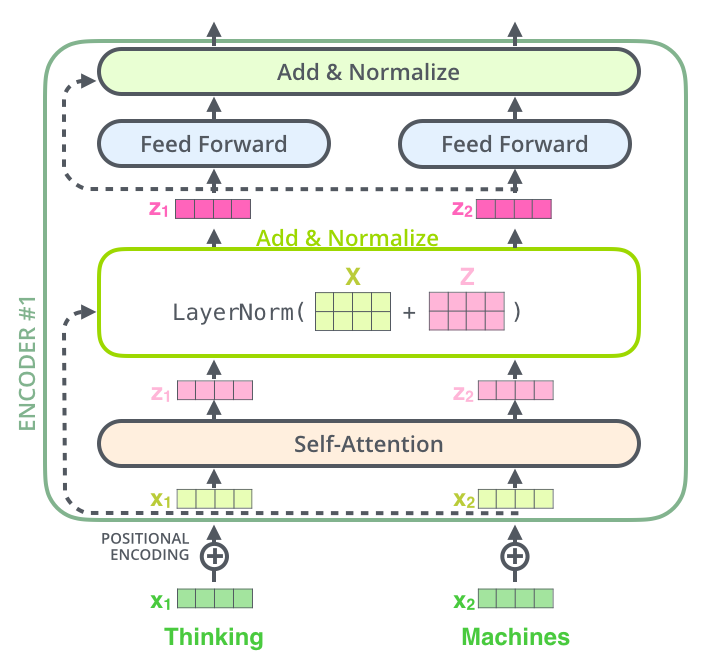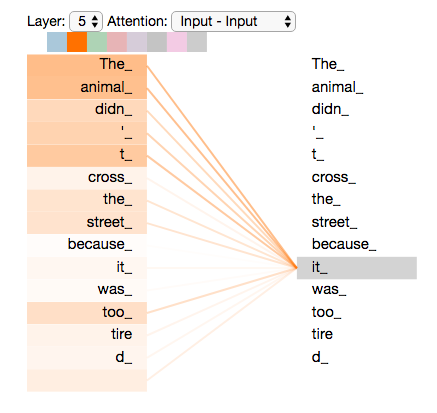

## Multi-Headed Attention
- Multi-head Attention is a module for attention mechanisms which runs through an attention mechanism several times in parallel. The independent attention outputs are then concatenated and linearly transformed into the expected dimension. 
- The Self Attention mechanism (illustrated in picture above next to the picture of encoder block) is used several times in parallel in Multi-Head attention
- Multiple attention heads allows for attending to parts of the sequence differently
- During self attention a word's attention score with itself will be the highest, therefore by using mutli-head attention a word can establish its relationship with other words in the sequence by calculating the attention scores with them in parallel 

In [28]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

## Model Definition

In [29]:
embed_dim = 50  
heads = 2  
neurons = 32
maxlen = 20
vocab_size = 20886

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.35)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 token_and_position_embeddin  (None, 20, 50)           1045300   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_encoder (Transf  (None, 20, 50)           23832     
 ormerEncoder)                                                   
                                                                 
 global_average_pooling1d (G  (None, 50)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_2 (Dropout)         (None, 50)                0     

## Model Training

In [33]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 1, verbose = 1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

In [34]:
history = model.fit(X_train,y_train,
                    validation_data=(X_val,y_val),
                    epochs=10,
                    batch_size=32,
                    callbacks=[earlystopping])

Epoch 1/10
1384/1384 [==============================] - 33s 24ms/step - loss: 0.1238 - accuracy: 0.9571 - val_loss: 0.2635 - val_accuracy: 0.9217
Epoch 2/10
1384/1384 [==============================] - 33s 24ms/step - loss: 0.0853 - accuracy: 0.9721 - val_loss: 0.2734 - val_accuracy: 0.9331
Epoch 2: early stopping


In [42]:
X_train

(44261, 20)

# Model Evaluation

## Learning Curves
- Loss Curve
- Accuracy Curve

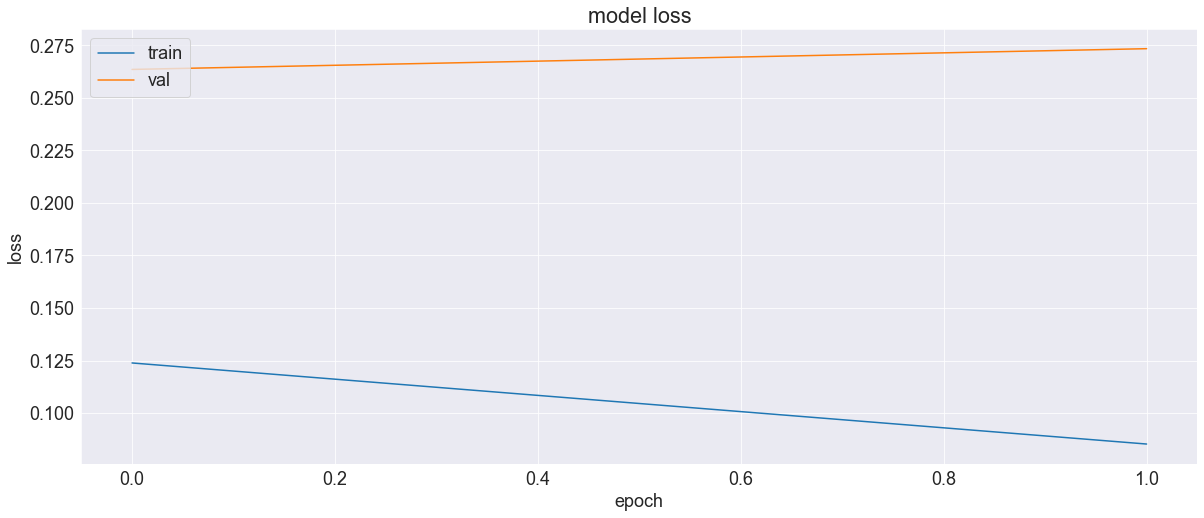

In [35]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

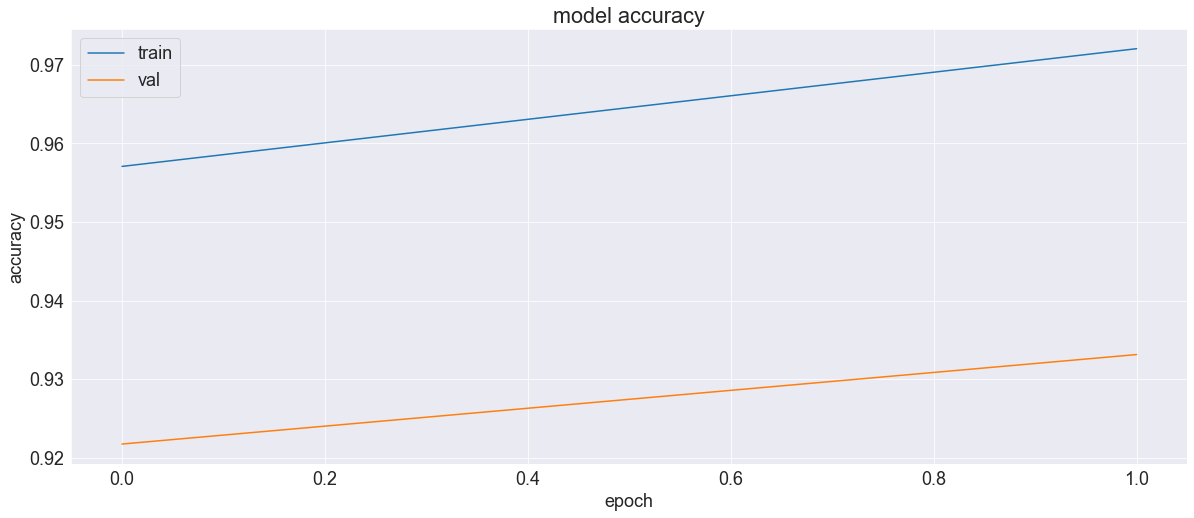

In [36]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

**Inference:** In case of overfitting use the traditional methods
- Low learning rate
- L1-L2 Regularization
- Dropout
- Lesser Neurons in MLP layers
- Early Stopping
- etc.

## Classification Metrics
- Since it is important to not misclassify the genuine headlines as sarcastic headlines we will also look at the roc auc score to avoid misclassification of genuine headlines as sarcastic headlines

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

### ROC Curve

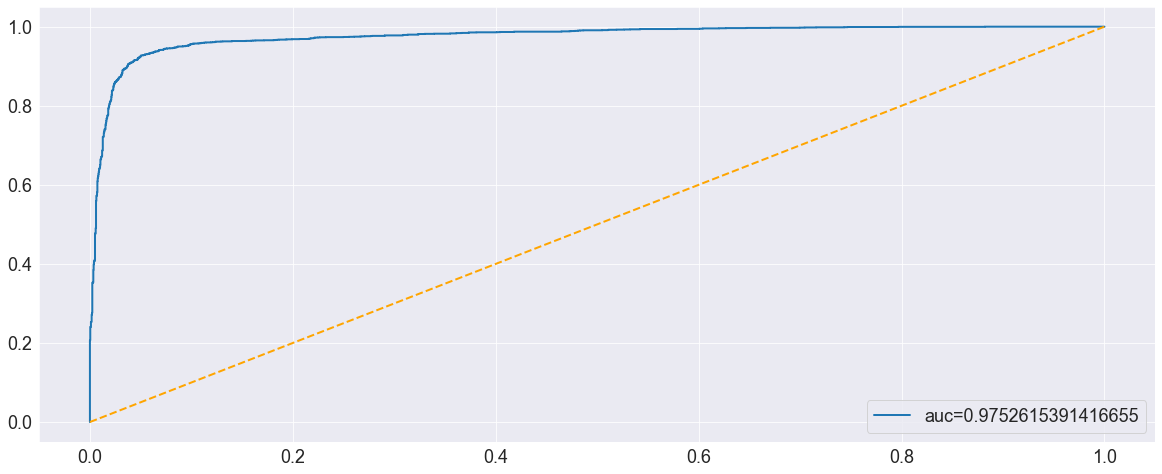

In [38]:
y_pred = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

### Scores: Test Set Result

In [39]:
y_pred[y_pred>=0.85] = 1
y_pred[y_pred<0.85] = 0

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93      2997
           1       0.96      0.87      0.92      2536

    accuracy                           0.93      5533
   macro avg       0.93      0.92      0.92      5533
weighted avg       0.93      0.93      0.93      5533



### Confusion Matrix

<AxesSubplot:>

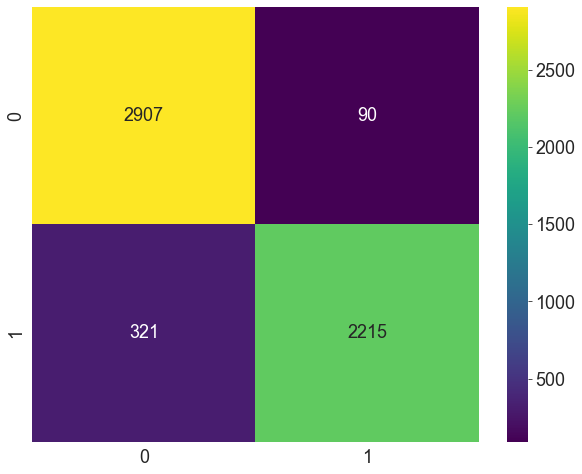

In [40]:
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.4g',cmap='viridis')